This notebook has been modified from SPECFEM Users Workshop by Visrutha 
visrutha.c@students.iiserpune.ac.in

In this notebook we will be using SPECFEM3D_Cartesian.  
- **Any subsequent use of the term 'SPECFEM3D' will refer to  'SPECFEM3D_cartesian'** and not the other variants (SPECFEM3D_GLOBE, etc).
- The best reference on how to set up and use SPECFEM3D would be the user [manual](https://github.com/geodynamics/specfem3d/blob/devel/doc/USER_MANUAL/manual_SPECFEM3D_Cartesian.pdf).  

- In this short introduction, we will explore the SPECFEM3D repository, and then run small example problems with 3D models, starting with a homogeneous halfspace example. 

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

### 1) SPECFEM3D Directory Tour

### 1a) Getting started

To get started, do the following:

1. download specfem3d (*git clone*) : `git clone --recursive --branch devel https://github.com/SPECFEM/specfem3d.git`
1. configure (*./configure*) : `./configure FC=gfortran CC=gcc MPIFC=mpif90 --with-mpi` - can replace the GNU compilers above (gfortran and gcc) with other compilers if you want to; for instance for
Intel ifort and icc use FC=ifort CC=icc instead. If you plan to run on one processor, use `./configure FC=gfortran CC=gcc`
3. compile (*make all*) SPECFEM2D : `make all` 

In [24]:
# Go to the SPECFEM3D directory
%cd /home/visrutha/specfem3d

# Exploring the SPECFEM3D directory
! ls

/home/visrutha/specfem3d
AUTHORS       configure.ac     external_libs  Makefile.in	   setup
bin	      CONTRIBUTING.md  flags.guess    MESH-default	   src
CITATION.cff  CUBIT_GEOCUBIT   install-sh     obj		   tests
config.guess  DATA	       lib	      OUTPUT_FILES	   utils
config.sub    doc	       LICENSE	      README.md		   VERSION
configure     EXAMPLES	       m4	      run_this_example.sh


### 1b) SPECFEM Executables in *bin/* directory
- Executables created by the compilation step are located in the `bin/` directory 

In [25]:
! ls bin

xadd_model_iso
xcheck_mesh_quality
xclip_sem
xcombine_sem
xcombine_surf_data
xcombine_vol_data
xcombine_vol_data_vtk
xcombine_vol_data_vtk_bin
xcombine_vol_data_vtu
xconvert_skewness_to_angle
xconvolve_source_timefunction
xcreate_movie_shakemap_AVS_DX_GMT
xdecompose_mesh
xdecompose_mesh_mpi
xdetect_duplicates_stations_file
xgenerate_databases
xinverse_problem_for_model
xmeshfem3D
xmodel_update
xproject_and_combine_vol_data_on_regular_grid
xsmooth_sem
xspecfem3D
xsum_kernels
xsum_preconditioned_kernels


- The most essential executables for a basic simulation are:  
    - `xmeshfem3D`: also called SPECFEM3D's internal mesher, this program discretizes the simulation domain into small elements  
    - `xgenerate_databases`: this database generation program assigns model parameter values to the elements  
    - `xspecfem3D`: also called the solver, this program uses the mesh and the corresponding model parameter values assigned to the mesh elements, for numerically solving the wave equation  
    
### 1b) ' DATA/ ' directory


In [26]:
! ls DATA

CMTSOLUTION    observation_grid_to_use_for_gravity.txt	STATIONS
FORCESOLUTION  Par_file					STATIONS_ADJOINT


The `DATA/` folder is the input files folder and contains files and folders which describe the -
- mesh: (`meshfem3D_files/`)
- model: (`meshfem3D_files/`, `tomo_files/`)
- source: (`CMTSOLUTION`, `FORCESOLUTION`)
- station: (`STATIONS`)

### 1c) ' OUTPUT_FILES/ ' directory

In [27]:
! ls OUTPUT_FILES

DATABASES_MPI


- This `OUTPUT_FILES/` folder contains the output files of any SPECFEM3D job.   
- The `DATABASES_MPI/` folder in the `OUTPUT_FILES/` folder contains the database files generated as a result of a meshing or database generation job. The database files can be very large in size.  
- Other job files like log files for the various programs as well as the output seismograms are directly generated in the `OUTPUT_FILES/` folder.

### 1d) ' EXAMPLES/ ' directory

In [28]:
! ls EXAMPLES

applications
benchmarks
notebooks
process_DATA_Par_files_to_update_their_parameters_from_a_main_file.py
README.md
reproducible_study


In [29]:
! ls EXAMPLES/applications

coffee_mug_with_fluid_inside
CPML_examples
decompose_mesh_MPI
decompose_mesh_MPI_with_faults
fault_examples
Gmsh_simple_box_hex27
Gmsh_simple_lddrk
homogeneous_acoustic
homogeneous_halfspace
homogeneous_halfspace_HEX27_elastic_no_absorbing
homogeneous_halfspace_HEX8_elastic_absorbing_Stacey_5sides
homogeneous_halfspace_HEX8_elastic_no_absorbing
homogeneous_poroelastic
inversion_examples
layered_halfspace
LTS_homogeneous_halfspace_HEX8
meshfem3D_examples
Mount_StHelens
noise_non_uniform
noise_tomography
oldstuff
README.md
small_adjoint_multiple_sources
small_example_coupling_axisem_specfem
small_example_coupling_FK_specfem
small_example_coupling_FK_specfem_with_fluid
small_example_coupling_SPECFEM_specfem
tomographic_model
waterlayered_halfspace
waterlayered_poroelastic
wavefield_discontinuity


- The `EXAMPLES/` folder contains a variety of examples to provide a quick start to the user on how to use SPECFEM3D and its various features. 
- The README files within the example folders within `EXAMPLES/` guide the user through the steps to run each example.  
- Some of the highly recommended examples to start with, depending on your need to run SPECFEM3D, are:
    - `applications/homogeneous_halfspace/` - a simple homogeneous halfspace model based simulation
    - `applications/meshfem3D_examples/socal1D/` - a layered model based simulation
    - `reproducible_study/sensitivity_kernels_liutromp2006/` - adjoint simulations to generate the kernels in [Liu&Tromp 2006](https://pubs.geoscienceworld.org/ssa/bssa/article/96/6/2383/146674/Finite-Frequency-Kernels-Based-on-Adjoint-Methods)

- Here we will start with the `homogeneous halfspace/` example, and then move on to running simulations with layered models.  
- We will also discuss some strategies to design meshes using SPECFEM3D's internal mesher. 

## 2) Setting Up Simulations

- It is often desirable to run SPECFEM outside of the cloned SPECFEM repository, in order to keep files and outputs manageable. 
- SPECFEM3D only requires the following 3 directories for a successful run -
    - `bin/` (with compiled executables)
    - `DATA/` (with the necessary input files)
    - `OUTPUT_FILES/`

In this section we will set up a separate SPECFEM3D working directory to work with.


In [30]:
# Create separate working directory for SPECFEM3D
! mkdir -p /home/visrutha/work/specfem3d_workdir

# Go to the SPECFEM3D working directory
%cd /home/visrutha/work/specfem3d_workdir

# Symlink the binary files    and copy the relevant DATA/ directory
! ln -s /home/visrutha/specfem3d/bin .
! mkdir -p OUTPUT_FILES/DATABASES_MPI

# Look at the work directory
! ls

/home/visrutha/work/specfem3d_workdir
bin  OUTPUT_FILES


### 3) Simulations

A SPECFEM3D simulation primarily involves three steps -
- meshing
- database generation
- solving the wave equation

We will go through these steps in the following example.

#### 3a) Homogeneous Halfspace

In [31]:
# Copy necessary input files for the homogeneous halfspace example
! cp -r /home/visrutha/specfem3d/EXAMPLES/applications/homogeneous_halfspace/DATA .
! cp -r /home/visrutha/specfem3d/EXAMPLES/applications/homogeneous_halfspace/meshfem3D_files DATA/.

# Look at the DATA directory
! ls DATA

CMTSOLUTION	 observation_grid_to_use_for_gravity.txt  STATIONS_ADJOINT
FORCESOLUTION	 Par_file
meshfem3D_files  STATIONS


##### Step 1) Meshing: Simulation domain discretization

In [32]:
# Explore the mesh files
! ls DATA/meshfem3D_files

interface1.txt	interfaces.txt	Mesh_Par_file


In [ ]:
# Run mesher (xmeshfem3D)
! mpirun -n 4 ./bin/xmeshfem3D

# Look at the generated mesh files
! ls OUTPUT_FILES/DATABASES_MPI

proc000000_Database	 proc000001_mesh.vtk	  proc000002_skewness.vtk
proc000000_mesh.vtk	 proc000001_skewness.vtk  proc000003_Database
proc000000_skewness.vtk  proc000002_Database	  proc000003_mesh.vtk
proc000001_Database	 proc000002_mesh.vtk	  proc000003_skewness.vtk


##### Step 2) Database Generation: Model assignment to mesh

In [ ]:
# Run database generator (xgenerate_databases)
! mpirun -n 4 ./bin/xgenerate_databases

# Explore the generated database files
! ls OUTPUT_FILES/DATABASES_MPI

proc000000_Database		   proc000002_Database
proc000000_external_mesh.bin	   proc000002_external_mesh.bin
proc000000_free_surface.vtk	   proc000002_free_surface.vtk
proc000000_ibool.bin		   proc000002_ibool.bin
proc000000_jacobian_min.vtu	   proc000002_jacobian_min.vtu
proc000000_mesh.vtk		   proc000002_mesh.vtk
proc000000_MPI_points.vtk	   proc000002_MPI_points.vtk
proc000000_qkappa.bin		   proc000002_qkappa.bin
proc000000_qkappa.vtk		   proc000002_qkappa.vtk
proc000000_qmu.bin		   proc000002_qmu.bin
proc000000_qmu.vtk		   proc000002_qmu.vtk
proc000000_res_dt_suggested.vtu    proc000002_res_dt_suggested.vtu
proc000000_res_minimum_period.vtu  proc000002_res_minimum_period.vtu
proc000000_rho.bin		   proc000002_rho.bin
proc000000_skewness.vtk		   proc000002_skewness.vtk
proc000000_vp.bin		   proc000002_vp.bin
proc000000_vp.vtk		   proc000002_vp.vtk
proc000000_vs.bin		   proc000002_vs.bin
proc000000_vs.vtk		   proc000002_vs.vtk
proc000000_x.bin		   proc000002_x.bin
proc000000_y.bin		   pro

##### Step 3) Simulation: Solving the wave equation

In [ ]:
# Check the source definition
! cat DATA/CMTSOLUTION

In [39]:
# Check the stations file
! cat DATA/STATIONS

X20 DB 67000.00 22732.14 0.0 0.0
X30 DB 67000.00 34696.43 0.0 0.0
X40 DB 67000.00 46660.71 0.0 0.0
X50 DB 67000.00 58625.00 0.0 0.0


In [ ]:
# Run the solver (xspecfem3D)
%time ! mpirun -n 4 ./bin/xspecfem3D

CPU times: user 10.9 s, sys: 831 ms, total: 11.7 s
Wall time: 5min 59s


In [42]:
# Look at the simulation output files
! ls OUTPUT_FILES/

DATABASES_MPI	 DB.X50.BXZ.semd		  timestamp000005
DB.X20.BXX.semd  error_message000000.txt	  timestamp000500
DB.X20.BXY.semd  mesh_quality_histogram.txt	  timestamp001000
DB.X20.BXZ.semd  output_generate_databases.txt	  timestamp001500
DB.X30.BXX.semd  output_list_sources.txt	  timestamp002000
DB.X30.BXY.semd  output_list_stations.txt	  timestamp002500
DB.X30.BXZ.semd  output_meshfem3D.txt		  timestamp003000
DB.X40.BXX.semd  output_solver.txt		  timestamp003500
DB.X40.BXY.semd  plot_mesh_quality_histogram.gnu  timestamp004000
DB.X40.BXZ.semd  sr.vtk				  timestamp004500
DB.X50.BXX.semd  starttimeloop.txt		  timestamp005000
DB.X50.BXY.semd  surface_from_mesher.h		  values_from_mesher.h


In [43]:
# Explore the seismograms
! head -25 OUTPUT_FILES/DB.X50.BXZ.semd 

  -10.0000000       0.00000000    
  -9.94999981       0.00000000    
  -9.89999962       0.00000000    
  -9.85000038       0.00000000    
  -9.80000019       0.00000000    
  -9.75000000       0.00000000    
  -9.69999981       0.00000000    
  -9.64999962       0.00000000    
  -9.60000038       0.00000000    
  -9.55000019      -6.22681108E-22
  -9.50000000      -6.69273126E-21
  -9.44999981      -2.77860308E-20
  -9.39999962      -4.33727186E-21
  -9.35000038       6.08116975E-19
  -9.30000019       4.13693208E-18
  -9.25000000       1.72378782E-17
  -9.19999981       5.32048129E-17
  -9.14999962       1.27827727E-16
  -9.10000038       2.36291143E-16
  -9.05000019       2.98326328E-16
  -9.00000000       7.95158731E-17
  -8.94999981      -8.47516285E-16
  -8.89999962      -2.95600565E-15
  -8.85000038      -6.23830067E-15
  -8.80000019      -9.21666206E-15


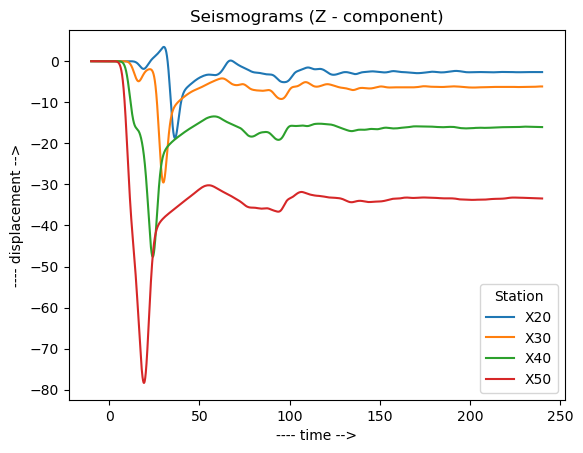

In [48]:
# Load seismograms
X20_Z = np.genfromtxt("OUTPUT_FILES/DB.X20.BXZ.semd", dtype=None, names=("time", "BXZ"))
X30_Z = np.genfromtxt("OUTPUT_FILES/DB.X30.BXZ.semd", dtype=None, names=("time", "BXZ"))
X40_Z = np.genfromtxt("OUTPUT_FILES/DB.X40.BXZ.semd", dtype=None, names=("time", "BXZ"))
X50_Z = np.genfromtxt("OUTPUT_FILES/DB.X50.BXZ.semd", dtype=None, names=("time", "BXZ"))

t = X20_Z["time"]

# Plot
plt.figure()
plt.title("Seismograms (Z - component)")
plt.xlabel("---- time -->")
plt.ylabel("---- displacement -->")

plt.plot(t, X20_Z["BXZ"], label="X20")
plt.plot(t, X30_Z["BXZ"], label="X30")
plt.plot(t, X40_Z["BXZ"], label="X40")
plt.plot(t, X50_Z["BXZ"], label="X50")

plt.legend(title="Station")
#plt.savefig("seis.png")
plt.show()


In [54]:
! ls OUTPUT_FILES/DATABASES_MPI/*vtk

OUTPUT_FILES/DATABASES_MPI/proc000000_free_surface.vtk
OUTPUT_FILES/DATABASES_MPI/proc000000_mesh.vtk
OUTPUT_FILES/DATABASES_MPI/proc000000_MPI_points.vtk
OUTPUT_FILES/DATABASES_MPI/proc000000_qkappa.vtk
OUTPUT_FILES/DATABASES_MPI/proc000000_qmu.vtk
OUTPUT_FILES/DATABASES_MPI/proc000000_skewness.vtk
OUTPUT_FILES/DATABASES_MPI/proc000000_vp.vtk
OUTPUT_FILES/DATABASES_MPI/proc000000_vs.vtk
OUTPUT_FILES/DATABASES_MPI/proc000001_free_surface.vtk
OUTPUT_FILES/DATABASES_MPI/proc000001_mesh.vtk
OUTPUT_FILES/DATABASES_MPI/proc000001_MPI_points.vtk
OUTPUT_FILES/DATABASES_MPI/proc000001_qkappa.vtk
OUTPUT_FILES/DATABASES_MPI/proc000001_qmu.vtk
OUTPUT_FILES/DATABASES_MPI/proc000001_skewness.vtk
OUTPUT_FILES/DATABASES_MPI/proc000001_vp.vtk
OUTPUT_FILES/DATABASES_MPI/proc000001_vs.vtk
OUTPUT_FILES/DATABASES_MPI/proc000002_free_surface.vtk
OUTPUT_FILES/DATABASES_MPI/proc000002_mesh.vtk
OUTPUT_FILES/DATABASES_MPI/proc000002_MPI_points.vtk
OUTPUT_FILES/DATABASES_MPI/proc000002_qkappa.vtk
OUTPUT_FILES/D

- In the DATABASES_MPI folder, for each processor .vtk files will be created which can be visualized in paraview. Here, for 4 processors we will have 4 files.
- Also, we can create a single file from the binary files created using the executable **xcombine_vol_data_vtk**


In [55]:
! ./bin/xcombine_vol_data_vtk 0 3 vs ./OUTPUT_FILES/DATABASES_MPI ./OUTPUT_FILES 0


 Recombining ParaView data for slices

 combine volumetric data
   mesh topology dir : ./OUTPUT_FILES/DATABASES_MPI
   input file    dir : vs

   output directory  : ./OUTPUT_FILES
   using VTK format for file output

 Slice list: 
           0           1           2           3


 VTK initial total points:        24548
 VTK initial total elements:        20736

  
 Reading slice            0
   file: ./OUTPUT_FILES/DATABASES_MPI/proc000000_vs.bin
   min/max value:    1500.00000       1500.00000    

   points:           0        6137
  
 Reading slice            1
   file: ./OUTPUT_FILES/DATABASES_MPI/proc000001_vs.bin
   min/max value:    1500.00000       1500.00000    

   points:        6137        6137
  
 Reading slice            2
   file: ./OUTPUT_FILES/DATABASES_MPI/proc000002_vs.bin
   min/max value:    1500.00000       1500.00000    

   points:       12274        6137
  
 Reading slice            3
   file: ./OUTPUT_FILES/DATABASES_MPI/proc000003_vs.bin
   min/max value: 

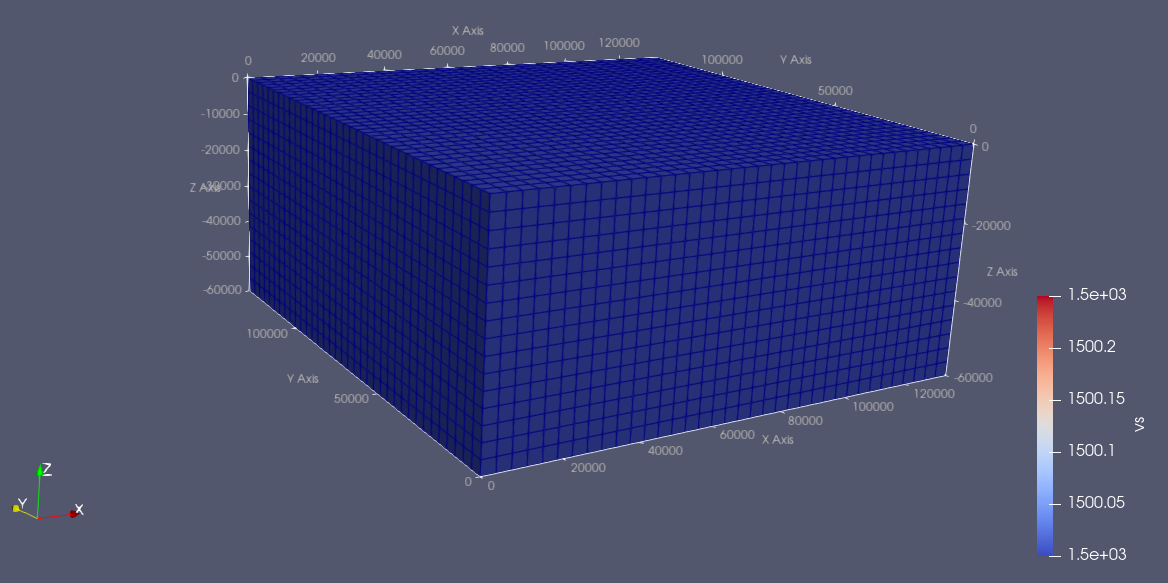

In [62]:
# View the meshing and the Vp model
# The following image was generated using Paraview
! cp ../example_homogeneous.png .
Image("example_homogeneous.png")

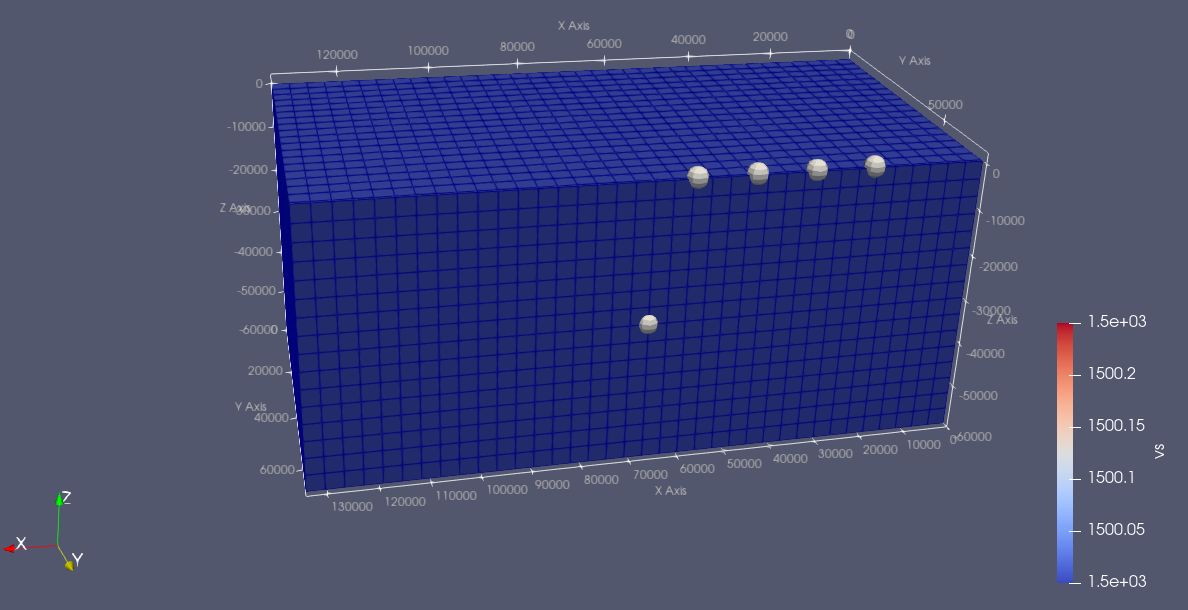

In [63]:
! cp ../sr_example_homo.png .
Image("sr_example_homo.png")